<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/lab_solutions/Labs/Lab08_interpolation_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8: Interpolation (SOLUTIONS)

Learning objectives:
- Explore interpolation conceptually, **not** focusing on formulas like the Barycentric formula nor Newton's divided differences
- Visualize how Lagrange polynomials work
- If the data $y$ are generated by $y=f(x)$, and we interpolate with a polynomial $p$, then we have an error $e(x) = f(x)-p(x)$
  - Explore where (in the $x$ domain) the error is the highest
  - Consider using nonuniformly spaced $x$ nodes and see the effect on error
  - If we refine with $n\to \infty$, does $|e(x)|$ get smaller? Is this true for some functions but not others? What properties of the functions might affect it?
- Understand that polynomial interpolation comes down to linear algebra
  - The Vandermonde matrices for a given basis are useful (even if our practical formulas avoid forming/solving them explicitly)

Tasks:
1. Lagrange interpolation "by hand"
2. Trying different node locations: uniform or nonuniform (clustered near edges)
3. Look at the error formula for 3 functions, $f(x)=e^{-x}$, $f(x)=\frac{1}{1+x^2}$, and $f(x)=|x|$.
4. Make Vandermonde matrices by hand; solve for the coefficients; and create the polynomial

*If you are super speedy and finish everything quickly, then look into https://github.com/chebpy/chebpy, a Python wrapper for [chebfun](https://www.chebfun.org/), which is a numerical package (originally in Matlab) for defining functions via their polynomial interpolants (using the [Chebyshev polynomial basis](https://en.wikipedia.org/wiki/Chebyshev_polynomials) )*

**Deliverables**

Turn in a **single PDF** with the following items:
- from Task 1, a plot of the $k=2$ Lagrange polynomial for the given nodes described in that task
- from Task 2, a plot of the error, for $n-9$, for both uniform and nonuniform nodes (combined onto a single plot)
- from Task 3, a sentence commenting on your results (if you finished) or speculation on what your results would be (if you didn't finish)
No deliverables from Task 4 are required

APPM 4600. Copyright Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause license

In [1]:
import numpy as np
import scipy.interpolate
import sympy
from   matplotlib import pyplot as plt

## Part 1: Lagrange interpolation "by hand"
We'll do Lagrange interpolation, but do it manually, not using the Barycentric formula. This is for illustrative purposes

Use the `xData` and `yData` points given below (both of length 5). Create a Python function that returns the $k^\text{th}$ Lagrange polynomial (for $k=0,1,2,3,4$) for these `xData` nodes.  Plot the $k=2$ polynomial (evaluating it at 50 points) in the range $[1,5]$.

1.0


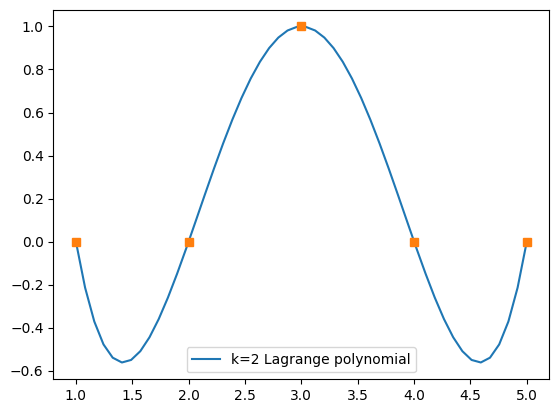

In [2]:
xData = np.arange(1,6)
yData = np.array( [3.1, 1.6, 3.5, 4.6, 5.8])

k = 2

def L(k):
    """ creates a function that returns the kth Lagrange polynomial"""
    @np.vectorize
    def L(x):
        """ returns the value of the kth Lagrange polynomial,
        evaluated at a given point x
        (note: k is 0-indexed) """
        y = 1.
        # This is one possible implementation
        for j in range(k):
            y *= (x-xData[j])/( xData[k]-xData[j])
        for j in range(k+1,len(xData)):
            y *= (x-xData[j])/( xData[k]-xData[j])
        return y
    return L

Lk = L(k)

# Or, another way
def L(x,k):
    """ returns the value of the kth Lagrange polynomial,
    evaluated at a given point x
    (note: k is 0-indexed) """
    y = 1.
    # This is one possible implementation
    for j in range(k):
        y *= (x-xData[j])/( xData[k]-xData[j])
    for j in range(k+1,len(xData)):
        y *= (x-xData[j])/( xData[k]-xData[j])
    return y

Lk = lambda x : L(x,k)

print( Lk( xData[k] ) )

xGrid = np.linspace(1,5,50) # for plotting
plt.plot( xGrid, Lk(xGrid), label=f'k={k} Lagrange polynomial')
plt.plot( xData, Lk(xData), 's')
plt.legend()
plt.show()

Now build the interpolating polynomial. You don't need to do this in an "automated" fashion. Plot this polynomial (again, at 50 data points in the range $[1,5]$) as well as the original `xData` and `yData`

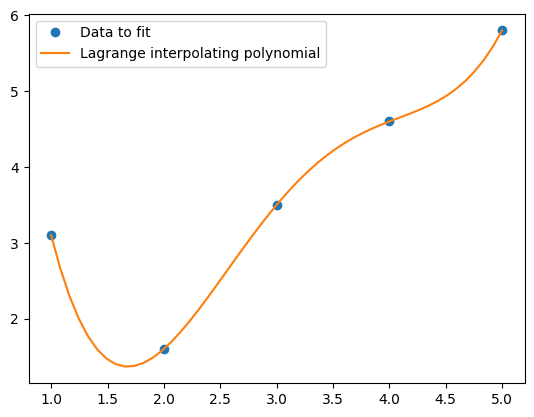

In [3]:
def p(x):
    y = 0.
    for k in range(5):
        y += yData[k]*L(x,k)
    return y

plt.plot(xData,yData, 'o', label='Data to fit')
xGrid = np.linspace(1,5,50) # for plotting
plt.plot( xGrid, p(xGrid), label='Lagrange interpolating polynomial')
plt.legend()
plt.show()

## Part 2: Node locations
Consider the function $f(x) = e^{-5x^2}$ on the interval $[-1,1]$, and take $n+1$ nodes on $[-1,1]$. Evaluate $f$ on these nodes to get the $y$ values.  Using the $x$ and $y$ data, create the interpolating polynomial $p(x)$ using `scipy.interpolate.BarycentricInterpolator`

1. Do this for **equally spaced** nodes, e.g., `np.linspace(-1,1,n+1)`
2. Repeat this for the following **unequally** spaced nodes: $x_j = \cos(\frac{j\pi}{n})$ for $j=0,1,\ldots,n$. (These are the "Chebyshev points" used in [Clenshaw-Curtis quadrature](https://epubs.siam.org/doi/epdf/10.1137/060659831))

Do this for $n=9$ (so 10 points total)

In both cases, make a plot of:
1. the data and both interpolants $p(x)$
2. the error between the original function $f(x)$ and both interpolants $p(x)$
For the plot, evaluate on a fine grid, e.g., 200 equally spaced points between $[-1,1]$

Answer the following questions:
1. For **equally spaced nodes**, where is most of the error located (in terms of $x$ values), e.g., near the center? near the edges?
2. If you make $n=19$, compare the maximum error $f(x)-p(x)$ for both cases. Which type of nodes (equally spaced or unequally spaced) has less error?

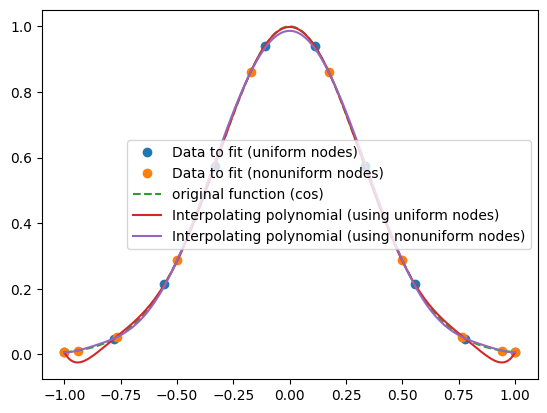

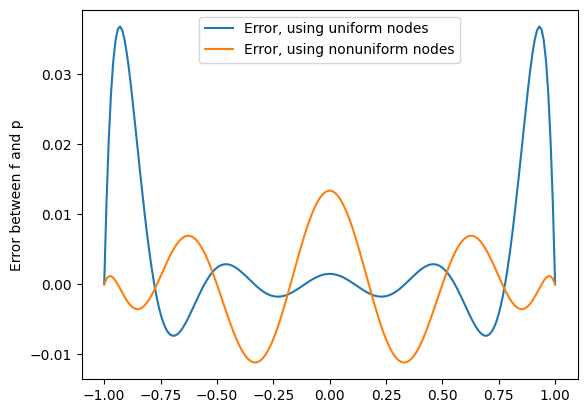

In [4]:
a, b = -1, 1
f = lambda x : np.exp(-5*x**2)

n     = 9
xData1 = np.linspace(a,b,n+1)
yData1 = f(xData1)

xData2 = np.cos( np.arange(n+1)*np.pi/n )
yData2 = f(xData2)
p1    = scipy.interpolate.BarycentricInterpolator(xData1,yData1)
p2    = scipy.interpolate.BarycentricInterpolator(xData2,yData2)

xGrid = np.linspace(a,b,200) # for plotting
plt.plot( xData1, yData1, 'o', label='Data to fit (uniform nodes)')
plt.plot( xData2, yData2, 'o', label='Data to fit (nonuniform nodes)')
plt.plot( xGrid, f(xGrid), '--', label='original function (cos)')
plt.plot( xGrid, p1(xGrid), label='Interpolating polynomial (using uniform nodes)')
plt.plot( xGrid, p2(xGrid), label='Interpolating polynomial (using nonuniform nodes)')
plt.legend()
plt.show()
# Or, plot the error
plt.plot( xGrid, f(xGrid)-p1(xGrid), label='Error, using uniform nodes' )
plt.plot( xGrid, f(xGrid)-p2(xGrid), label='Error, using nonuniform nodes' )
plt.legend()
plt.ylabel('Error between f and p')
plt.show()

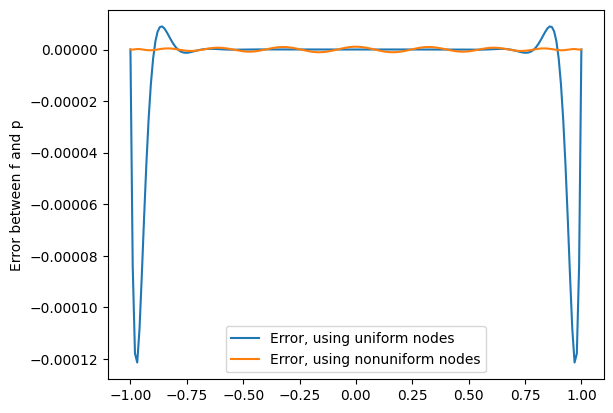

In [5]:
# Repeat, but for larger n
n     = 19
xData1 = np.linspace(a,b,n+1)
yData1 = f(xData1)

xData2 = np.cos( np.arange(n+1)*np.pi/n )
yData2 = f(xData2)
p1    = scipy.interpolate.BarycentricInterpolator(xData1,yData1)
p2    = scipy.interpolate.BarycentricInterpolator(xData2,yData2)

xGrid = np.linspace(a,b,200) # for plotting
# plot the error
plt.plot( xGrid, f(xGrid)-p1(xGrid), label='Error, using uniform nodes' )
plt.plot( xGrid, f(xGrid)-p2(xGrid), label='Error, using nonuniform nodes' )
plt.legend()
plt.ylabel('Error between f and p')
plt.show()

## Part 3: Error formulas for different types of functions
If $p_n$ is the interpolating polynomial on $n+1$ nodes $\{x_0,x_1,\ldots,x_n\}$ then we have the Lagrange remainder formula

$$f(x) - p_n(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i=0}^n (x-x_i)$$
for some $\xi$ in between the nodes. (See our notes, or our book, or [wikipedia: "Interpolation error: Lagrange remainder formula"](https://en.wikipedia.org/wiki/Polynomial_interpolation#Interpolation_error:_Lagrange_remainder_formula))

### Part 3a
Compare the error, using three different "$f$" functions:
1. $f(x)=e^{-x}$
2. $f(x) = \frac{1}{1+x^2}$
3. $f(x)=|x|$

on $[-5,5]$ using $n+1$ **equispaced nodes**.

Record and the maximum error, $\max_{x\in[-5,5]} |f(x)-p(x)|$, for each choice of $f$ and its respective interpolant.  (You don't need to calculate this error exactly, just approximate it by evaluating $f(x)-p(x)$ on a dense grid of $x$ points, e.g., 200 $x$ values in $[-5,5]$ is plenty).

Record this max error as a function of $n$, for $n=1,2,\ldots,20$.

(You may find it helpful to plot $f(x)$ and $p(x)$ if you like)

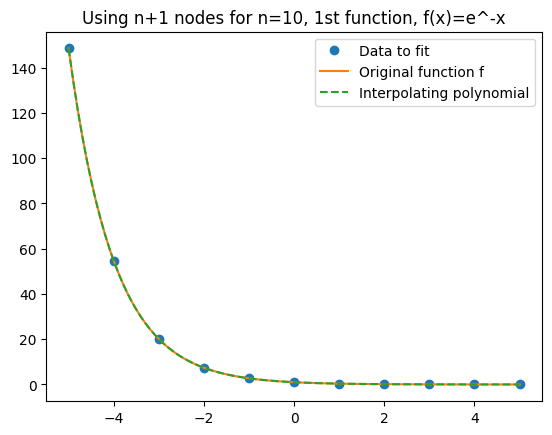

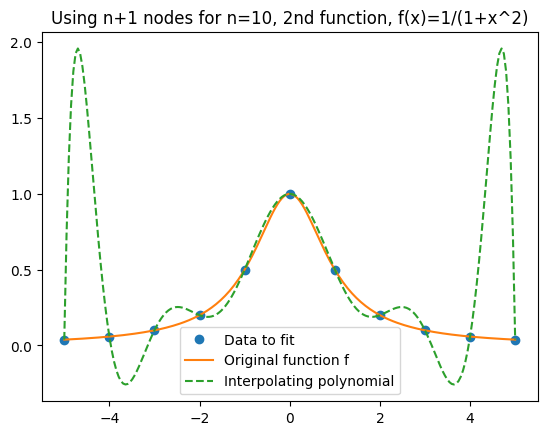

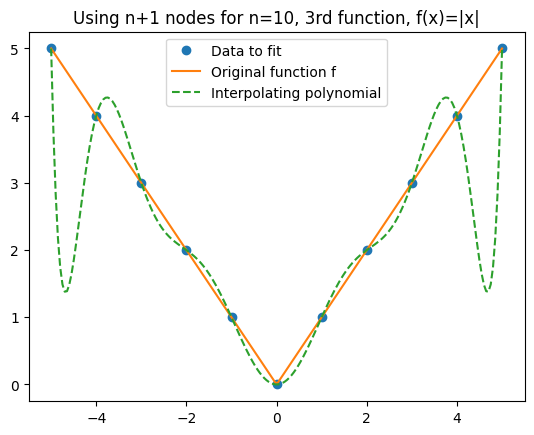

In [6]:
a, b = -5, 5

xGrid = np.linspace(a,b,200)

err1, err2, err3 = [], [], []
for n in range(1,20):

    xData = np.linspace(a,b,n+1)
    f1 = lambda x : np.exp(-x)
    f2 = lambda x : 1/(1+x**2)
    f3 = lambda x : np.abs(x)

    p1 = scipy.interpolate.BarycentricInterpolator(xData,f1(xData))
    p2 = scipy.interpolate.BarycentricInterpolator(xData,f2(xData))
    p3 = scipy.interpolate.BarycentricInterpolator(xData,f3(xData))

    err1.append( np.linalg.norm(p1(xGrid)-f1(xGrid), ord=np.inf) )
    err2.append( np.linalg.norm(p2(xGrid)-f2(xGrid), ord=np.inf) )
    err3.append( np.linalg.norm(p3(xGrid)-f3(xGrid), ord=np.inf) )

    if n == 10:
        plt.plot( xData, f1(xData), 'o', label='Data to fit')
        plt.plot( xGrid, f1(xGrid), label='Original function f')
        plt.plot( xGrid, p1(xGrid), '--',label='Interpolating polynomial')
        plt.title(f'Using n+1 nodes for {n=}, 1st function, f(x)=e^-x')
        plt.legend()
        plt.show()

        plt.plot( xData, f2(xData), 'o', label='Data to fit')
        plt.plot( xGrid, f2(xGrid), label='Original function f')
        plt.plot( xGrid, p2(xGrid), '--',label='Interpolating polynomial')
        plt.title(f'Using n+1 nodes for {n=}, 2nd function, f(x)=1/(1+x^2)')
        plt.legend()
        plt.show()

        plt.plot( xData, f3(xData), 'o', label='Data to fit')
        plt.plot( xGrid, f3(xGrid), label='Original function f')
        plt.plot( xGrid, p3(xGrid), '--',label='Interpolating polynomial')
        plt.title(f'Using n+1 nodes for {n=}, 3rd function, f(x)=|x|')
        plt.legend()
        plt.show()

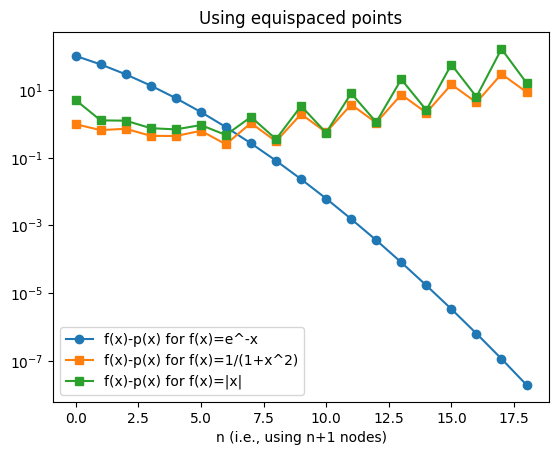

In [8]:
# Plot how the errors go down
plt.semilogy( range(19), err1,'o-', label='f(x)-p(x) for f(x)=e^-x' )
plt.semilogy( range(19), err2,'s-', label='f(x)-p(x) for f(x)=1/(1+x^2)' )
plt.semilogy( range(19), err3,'s-', label='f(x)-p(x) for f(x)=|x|' )
plt.legend()
plt.xlabel('n (i.e., using n+1 nodes)')
plt.title('Using equispaced points')
plt.show()

Observations: $f(x)=e^{-x}$ has the least error by far. The other functions have more error, and their error is concentrated toward the edges of the domain

### Part 3b: try the Chebyshev nodes
In our formula for the error, we have the term
$$f(x) - p_n(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i=0}^n (x-x_i)$$

We don't have control over $\xi$, but if we want to place nodes $n+1$ nodes $x_i$ in the interval $[-a,a]$, we could try to do so in a manner to minimize
$$\max_{x\in[-a,a]} \left| \prod_{i=0}^n (x-x_i) \right|.$$
Doing this leads to the Chebyshev nodes (scaled by $a$) that we already saw.

So let's repeat 3a but this time use Chebyshev nodes instead of uniform nodes. Does this help?

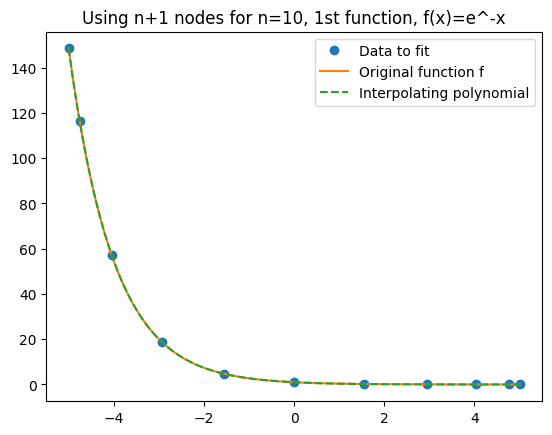

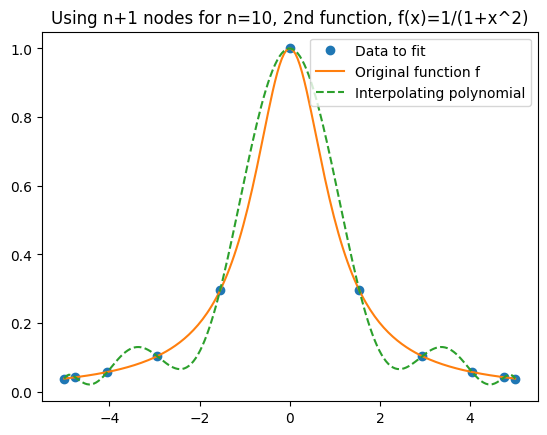

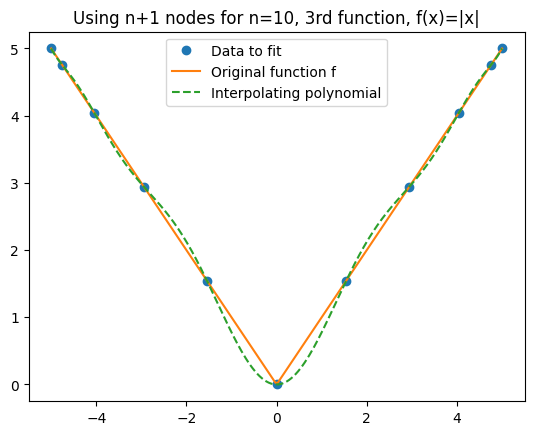

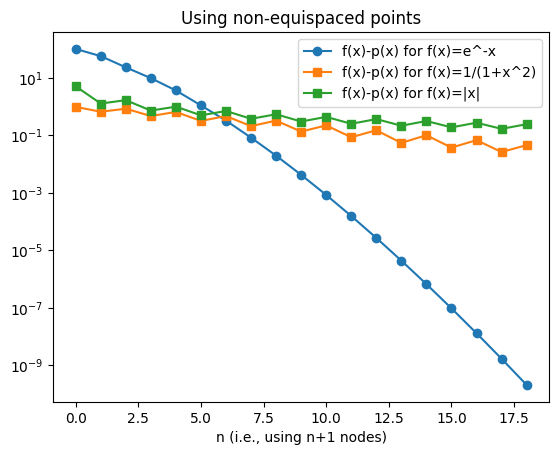

In [10]:
a, b = -5, 5

xGrid = np.linspace(a,b,200)

err1, err2, err3 = [], [], []
for n in range(1,20):

    # xData = np.linspace(a,b,n+1) # Don't use uniform nodes any more
    xData = 5*np.cos( np.arange(n+1)*np.pi/n )
    f1 = lambda x : np.exp(-x)
    f2 = lambda x : 1/(1+x**2)
    f3 = lambda x : np.abs(x)

    p1 = scipy.interpolate.BarycentricInterpolator(xData,f1(xData))
    p2 = scipy.interpolate.BarycentricInterpolator(xData,f2(xData))
    p3 = scipy.interpolate.BarycentricInterpolator(xData,f3(xData))

    err1.append( np.linalg.norm(p1(xGrid)-f1(xGrid), ord=np.inf) )
    err2.append( np.linalg.norm(p2(xGrid)-f2(xGrid), ord=np.inf) )
    err3.append( np.linalg.norm(p3(xGrid)-f3(xGrid), ord=np.inf) )

    if n == 10:
        plt.plot( xData, f1(xData), 'o', label='Data to fit')
        plt.plot( xGrid, f1(xGrid), label='Original function f')
        plt.plot( xGrid, p1(xGrid), '--',label='Interpolating polynomial')
        plt.title(f'Using n+1 nodes for {n=}, 1st function, f(x)=e^-x')
        plt.legend()
        plt.show()

        plt.plot( xData, f2(xData), 'o', label='Data to fit')
        plt.plot( xGrid, f2(xGrid), label='Original function f')
        plt.plot( xGrid, p2(xGrid), '--',label='Interpolating polynomial')
        plt.title(f'Using n+1 nodes for {n=}, 2nd function, f(x)=1/(1+x^2)')
        plt.legend()
        plt.show()

        plt.plot( xData, f3(xData), 'o', label='Data to fit')
        plt.plot( xGrid, f3(xGrid), label='Original function f')
        plt.plot( xGrid, p3(xGrid), '--',label='Interpolating polynomial')
        plt.title(f'Using n+1 nodes for {n=}, 3rd function, f(x)=|x|')
        plt.legend()
        plt.show()

plt.semilogy( range(19), err1,'o-', label='f(x)-p(x) for f(x)=e^-x' )
plt.semilogy( range(19), err2,'s-', label='f(x)-p(x) for f(x)=1/(1+x^2)' )
plt.semilogy( range(19), err3,'s-', label='f(x)-p(x) for f(x)=|x|' )
plt.legend()
plt.xlabel('n (i.e., using n+1 nodes)')
plt.title('Using non-equispaced points')
plt.show()

What's going on? We have our nice formula:
$$f(x) - p_n(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i=0}^n (x-x_i)$$

For $f(x)=\frac{1}{1+x^2}$, our error wasn't going down, but the function is $C^\infty(\mathbb{R})$. Did we make a mistake?

No, our formula was correct, the issue is that the $f'(\xi)$ term (and $f''(\xi)$, etc.) are very large.  One way to think of this issue is that the function has a **singularity** (though it is on the imaginary axis, at $\pm i$).

Btw, how do you prounce Runge? It's German, and you can listen to native speakers say it [at Forvo](https://forvo.com/search/Runge/)

Did the Chebyshev nodes help? No. We still have the fact that the derivatives are large.

For $f(x)=|x|$, the formula doesn't apply, because we're not differentiable! So that's another reason the error doesn't go down.

To recap, two common reasons the error doesn't go down with increasing nodes:
1. the derivatives don't exist
2. or, the derivatives exist but grow

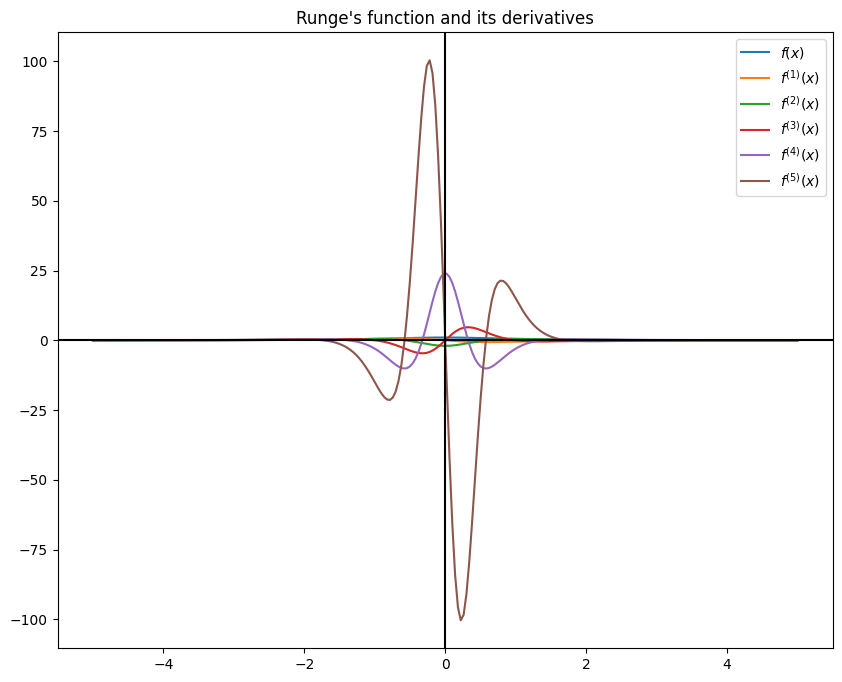

In [12]:
# We can see that the derivatives of the Runge function f(x)=1/(1+x^2) grow by checking in simpy

import sympy
from sympy.abc import x
from sympy import init_printing
from sympy.utilities.lambdify import lambdify
# sympy.init_printing()


f = lambda x : 1/(1+x**2)
F = lambda x : np.arctan(x)
a,b = -5,5

g = 1/(1+x**2) # symbolic version

gNumerical = lambdify(x,g) # avoid sympy plotting
xGrid   = np.linspace(a,b,250)
plt.figure(figsize=(10,8))
plt.plot( xGrid, gNumerical(xGrid),label='$f(x)$')


for k in range(1,6):
  dg = lambdify(x,sympy.diff(g,x,k))
  plt.plot( xGrid, dg(xGrid), label="$f^{("+str(k)+")}(x)$")
plt.axvline(color='k')
plt.axhline(color='k')
plt.legend()
plt.title("Runge's function and its derivatives")
del x # remove x as a symbolic variable

## Part 4: Generalized Vandermonde matrices for different bases

For each of the three sets of polynomial bases (monomials, Lagrange polynomials, and Newton polynomials), we have provided code below to generate a list that contains the polynomial functions of that basis.

Your job is to create the Vandermonde matrix (for the given nodes `xData`), and then find the coefficients by solving the linear system, and then using those coefficients to create the final interpolating polynomial.

In [13]:
n = 5
xData = np.linspace(10,11,n+1)
f     = lambda x : np.exp(-x)
yData = f(xData)

def createMonomialBasis(n):
    basis = []
    for k in range(n+1):
        # due to Python's "late binding" we have to do some tricks
        # See https://stackoverflow.com/a/2295372, https://stackoverflow.com/q/3431676
        basis.append(  lambda z,k=k : z**k )
    return basis

def createLagrangeBasis(n, xData):
    basis = []
    for k in range(n+1):
        def L_nk(x,k=k):
            y = 1.
            for j in range(k):
                y *= (x-xData[j])/( xData[k]-xData[j])
            for j in range(k+1,len(xData)):
                y *= (x-xData[j])/( xData[k]-xData[j])
            return y
        basis.append( L_nk )
    return basis

def createNewtonBasis(n,xData):
    basis = []
    for k in range(n+1):
        def L_nk(x,k=k):
            y = 1.
            for j in range(k):
                y *= (x-xData[j])
            return y
        basis.append( L_nk )
    return basis

def createVandermonde(xData,basis):
    #create this one row at a time
    A = np.array( [p(xData[0]) for p in basis] )
    for k in range(1,n+1):
        a = np.array( [p(xData[k]) for p in basis] )
        A = np.vstack( (A,a))
    return A

V_monomial = createVandermonde(xData, createMonomialBasis(n) )
V_shifted  = createVandermonde(xData-xData[0], createMonomialBasis(n) )
V_Lagrange = createVandermonde(xData, createLagrangeBasis(n,xData) )
V_Newton   = createVandermonde(xData, createNewtonBasis(n,xData) )

# For each basis, solve for the coefficients "c"
c_monomial = np.linalg.solve( V_monomial, yData )
p_monomial = lambda x : sum([c*p(x) for (c,p) in zip(c_monomial,createMonomialBasis(n))])

c_shifted = np.linalg.solve( V_shifted, yData )
p_shifted = lambda x : sum([c*p(x-xData[0]) for (c,p) in zip(c_shifted,createMonomialBasis(n))])

c_Lagrange = np.linalg.solve( V_Lagrange, yData )
p_Lagrange = lambda x : sum([c*p(x) for (c,p) in zip(c_Lagrange,createLagrangeBasis(n,xData))])

c_Newton = np.linalg.solve( V_Newton, yData )
p_Newton = lambda x : sum([c*p(x) for (c,p) in zip(c_Newton,createNewtonBasis(n,xData))])

xx = np.pi/4
print( p_monomial(xx) )
print( p_shifted(xx) )
print( p_Lagrange(xx) )
print( p_Newton(xx) )

# We'll treat this as the "ground truth" (it's a stable formula, and presumably a bug-free implementation):
p     = scipy.interpolate.BarycentricInterpolator(xData,yData)
print( p(xx) )

with np.printoptions(precision=2,suppress=True):
    print('Monomial basis')
    print(V_monomial)
    kappa = np.linalg.cond(V_monomial)
    print(f'Condition number of Vandermonde matrix is {kappa:.2e}')

    print('')
    print('Shifted Monomial basis')
    print(V_shifted)
    kappa = np.linalg.cond(V_shifted)
    print(f'Condition number of Vandermonde matrix is {kappa:.2e}')

    print('')
    print('Lagrange basis')
    print(V_Lagrange)
    kappa = np.linalg.cond(V_Lagrange)
    print(f'Condition number of Vandermonde matrix is {kappa:.2e}')

    print('')
    print('Newton basis')
    print(V_Newton)
    kappa = np.linalg.cond(V_Newton)
    print(f'Condition number of Vandermonde matrix is {kappa:.2e}')

0.03616053541969438
0.036160535866293
0.03616053586650736
0.036160535866259974
0.036160535751961036
Monomial basis
[[     1.       10.      100.     1000.    10000.   100000.  ]
 [     1.       10.2     104.04   1061.21  10824.32 110408.08]
 [     1.       10.4     108.16   1124.86  11698.59 121665.29]
 [     1.       10.6     112.36   1191.02  12624.77 133822.56]
 [     1.       10.8     116.64   1259.71  13604.89 146932.81]
 [     1.       11.      121.     1331.    14641.   161051.  ]]
Condition number of Vandermonde matrix is 1.88e+13

Shifted Monomial basis
[[1.   0.   0.   0.   0.   0.  ]
 [1.   0.2  0.04 0.01 0.   0.  ]
 [1.   0.4  0.16 0.06 0.03 0.01]
 [1.   0.6  0.36 0.22 0.13 0.08]
 [1.   0.8  0.64 0.51 0.41 0.33]
 [1.   1.   1.   1.   1.   1.  ]]
Condition number of Vandermonde matrix is 4.92e+03

Lagrange basis
[[ 1.  0. -0.  0. -0.  0.]
 [-0.  1.  0. -0.  0. -0.]
 [ 0. -0.  1.  0. -0.  0.]
 [-0.  0. -0.  1.  0. -0.]
 [ 0. -0.  0. -0.  1.  0.]
 [-0.  0. -0.  0. -0.  1.]]
Co

In [14]:
# Sanity check using some of numpy's builtin polynomial functionality
from numpy.polynomial import Polynomial
from numpy.polynomial import polynomial as P

with np.printoptions(precision=2,suppress=True):
    V_monomial = P.polyvander( xData, n )
    print('Monomial basis')
    print(V_monomial)
    kappa = np.linalg.cond(V_monomial)
    print(f'Condition number of Vandermonde matrix is {kappa:.2e}')

    print('')
    print('Shifted Monomial basis')
    V_shifted = P.polyvander( xData-xData[0], n )
    print(V_shifted)
    kappa = np.linalg.cond(V_shifted)
    print(f'Condition number of Vandermonde matrix is {kappa:.2e}')

    print('')
    print('Chebyshev basis')
    V_Cheb = np.polynomial.chebyshev.chebvander(xData,n)
    print(V_Cheb)
    kappa = np.linalg.cond(V_Cheb)
    print(f'Condition number of Vandermonde matrix is {kappa:.2e}')

Monomial basis
[[     1.       10.      100.     1000.    10000.   100000.  ]
 [     1.       10.2     104.04   1061.21  10824.32 110408.08]
 [     1.       10.4     108.16   1124.86  11698.59 121665.29]
 [     1.       10.6     112.36   1191.02  12624.77 133822.56]
 [     1.       10.8     116.64   1259.71  13604.89 146932.81]
 [     1.       11.      121.     1331.    14641.   161051.  ]]
Condition number of Vandermonde matrix is 1.88e+13

Shifted Monomial basis
[[1.   0.   0.   0.   0.   0.  ]
 [1.   0.2  0.04 0.01 0.   0.  ]
 [1.   0.4  0.16 0.06 0.03 0.01]
 [1.   0.6  0.36 0.22 0.13 0.08]
 [1.   0.8  0.64 0.51 0.41 0.33]
 [1.   1.   1.   1.   1.   1.  ]]
Condition number of Vandermonde matrix is 4.92e+03

Chebyshev basis
[[      1.        10.       199.      3970.     79201.   1580050.  ]
 [      1.        10.2      207.08    4214.23   85763.25 1745356.13]
 [      1.        10.4      215.32    4468.26   92724.4  1924199.36]
 [      1.        10.6      223.72    4732.26  100100.28 